In [ ]:
!pip install -q eval7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 675.3/675.3 kB 9.3 MB/s eta 0:00:00


In [ ]:
# CELL 1: Setup
!pip install -q rlcard

import numpy as np
import random
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

import rlcard
from rlcard.utils import tournament

print("✓ All dependencies installed!")
print(f"RLCard version: {rlcard.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.0/269.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
✓ All dependencies installed!
RLCard version: 1.2.0


In [ ]:
# CELL 2: MCCFR Agent Implementation

class MCCFRAgent:
    """
    Monte Carlo Counterfactual Regret Minimization Agent
    Uses External Sampling variant for efficiency
    """

    def __init__(self, num_actions=4):
        """Initialize MCCFR agent."""
        self.use_raw = False
        self.num_actions = num_actions

        # Regret and strategy storage
        self.regret_sum = defaultdict(lambda: np.zeros(num_actions))
        self.strategy_sum = defaultdict(lambda: np.zeros(num_actions))
        self.current_strategy = defaultdict(lambda: np.ones(num_actions) / num_actions)

        # Training statistics
        self.iteration = 0
        self.total_game_nodes = 0

    def get_strategy(self, info_set, legal_actions):
        """Compute current strategy using regret matching."""
        regrets = self.regret_sum[info_set]
        strategy = np.zeros(self.num_actions)

        # Get positive regrets
        positive_regrets = np.maximum(regrets, 0)

        # If we have positive regrets, use regret matching
        regret_sum = np.sum(positive_regrets[legal_actions])

        if regret_sum > 0:
            strategy[legal_actions] = positive_regrets[legal_actions] / regret_sum
        else:
            # Uniform distribution over legal actions
            strategy[legal_actions] = 1.0 / len(legal_actions)

        # Normalize to ensure valid probability distribution
        strategy[legal_actions] /= np.sum(strategy[legal_actions])

        return strategy

    def get_average_strategy(self, info_set=None):
        """Get average strategy (Nash approximation)."""
        if info_set is not None:
            strategy = self.strategy_sum[info_set]
            total = np.sum(strategy)
            if total > 0:
                return strategy / total
            else:
                return np.ones(self.num_actions) / self.num_actions
        else:
            # Return all average strategies
            avg_strategies = {}
            for info_set, strategy_sum in self.strategy_sum.items():
                total = np.sum(strategy_sum)
                if total > 0:
                    avg_strategies[info_set] = strategy_sum / total
                else:
                    avg_strategies[info_set] = np.ones(self.num_actions) / self.num_actions
            return avg_strategies

    def train_iteration(self, env, player_id=0):
        """Run one iteration of MCCFR (external sampling)."""
        state, player = env.reset()
        value = self._mccfr_external_sampling(env, player_id, 1.0, 1.0)
        self.iteration += 1
        return value

    def _mccfr_external_sampling(self, env, player_id, my_reach, opp_reach):
        """MCCFR traversal using external sampling."""
        state = env.get_state(player_id)

        # Terminal state - return payoff
        if env.is_over():
            return env.get_payoffs()[player_id]

        current_player = env.get_player_id()

        # Get information set (state representation)
        obs = state['obs']
        legal_actions = list(state['legal_actions'].keys())
        info_set = self._get_info_set(obs, legal_actions)

        self.total_game_nodes += 1

        # Current player is the one we're training
        if current_player == player_id:
            # Get current strategy
            strategy = self.get_strategy(info_set, legal_actions)

            # Store strategy for averaging
            self.strategy_sum[info_set] += my_reach * strategy

            # Compute value for each action
            action_values = np.zeros(self.num_actions)

            for action in legal_actions:
                # Step environment
                next_env = deepcopy(env)
                next_env.step(action)

                # Recursive call
                action_values[action] = self._mccfr_external_sampling(
                    next_env, player_id,
                    my_reach * strategy[action],
                    opp_reach
                )

            # Compute counterfactual value
            node_value = np.sum(strategy * action_values)

            # Update regrets
            for action in legal_actions:
                regret = action_values[action] - node_value
                self.regret_sum[info_set][action] += opp_reach * regret

            return node_value

        else:
            # Opponent's turn - sample one action (External Sampling)
            strategy = self.get_strategy(info_set, legal_actions)

            # Sample action according to strategy
            action = np.random.choice(legal_actions, p=strategy[legal_actions])

            # Step environment with sampled action
            env.step(action)

            # Recursive call
            return self._mccfr_external_sampling(
                env, player_id,
                my_reach,
                opp_reach * strategy[action]
            )

    def _get_info_set(self, obs, legal_actions):
        """Convert observation to information set string."""
        obs_str = ','.join([f'{x:.2f}' for x in obs[:10]])  # Use first 10 features
        actions_str = ','.join(map(str, sorted(legal_actions)))
        return f"{obs_str}|{actions_str}"

    def step(self, state):
        """Choose action during gameplay (uses average strategy)."""
        obs = state['obs']
        legal_actions = list(state['legal_actions'].keys())
        info_set = self._get_info_set(obs, legal_actions)

        strategy = self.get_average_strategy(info_set)
        probs = strategy[legal_actions]
        probs = probs / np.sum(probs)

        action = np.random.choice(legal_actions, p=probs)
        return action

    def eval_step(self, state):
        """Evaluation step (same as step, returns action and info)."""
        obs = state['obs']
        legal_actions = list(state['legal_actions'].keys())
        info_set = self._get_info_set(obs, legal_actions)

        strategy = self.get_average_strategy(info_set)
        probs = strategy[legal_actions]
        probs = probs / np.sum(probs)

        action = np.random.choice(legal_actions, p=probs)

        info = {
            'probs': {legal_actions[i]: probs[i] for i in range(len(legal_actions))},
            'values': {}
        }

        return action, info

    def save_model(self, filepath):
        """Save trained model."""
        model_data = {
            'regret_sum': dict(self.regret_sum),
            'strategy_sum': dict(self.strategy_sum),
            'iteration': self.iteration
        }
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"✓ Model saved to {filepath}")

    def load_model(self, filepath):
        """Load trained model."""
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        self.regret_sum = defaultdict(lambda: np.zeros(self.num_actions), model_data['regret_sum'])
        self.strategy_sum = defaultdict(lambda: np.zeros(self.num_actions), model_data['strategy_sum'])
        self.iteration = model_data['iteration']
        print(f"✓ Model loaded from {filepath} (iteration {self.iteration})")


print("✓ MCCFRAgent class defined successfully!")

✓ MCCFRAgent class defined successfully!


In [ ]:
# CELL 2.5: Define OddsAgentV21 for Comparison

import eval7

class OddsAgentV21(object):
    '''GTO-inspired poker agent using equity calculations and pot odds.'''

    def __init__(self, num_actions, threshold_offset=None):
        if threshold_offset is None:
            threshold_offset = {'preflop': 0, 'flop': 0, 'turn': 0, 'river': 0}

        self.use_raw = True
        self.num_actions = num_actions

        # Pre-calculated hand strength rankings
        self.preflop_value_dict = {
             '32o': 0.0, '42o': 0.006, '52o': 0.012, '62o': 0.018, '72o': 0.024,
             '32s': 0.030, '43o': 0.036, '63o': 0.042, '42s': 0.048, '53o': 0.054,
             '62s': 0.060, '73o': 0.065, '82o': 0.071, '72s': 0.077, '52s': 0.083,
             '54o': 0.089, '43s': 0.095, '83o': 0.101, '64o': 0.107, '74o': 0.113,
             '53s': 0.119, '63s': 0.125, '92o': 0.131, '84o': 0.137, '82s': 0.143,
             '65o': 0.149, '73s': 0.155, '83s': 0.161, '93o': 0.167, '75o': 0.173,
             '54s': 0.179, '94o': 0.185, '64s': 0.190, 'T2o': 0.196, '85o': 0.202,
             '74s': 0.208, '76o': 0.214, '84s': 0.220, '92s': 0.226, 'T3o': 0.232,
             '95o': 0.238, '65s': 0.244, '94s': 0.250, '93s': 0.256, 'T4o': 0.262,
             '86o': 0.268, '75s': 0.274, '76s': 0.280, '96o': 0.286, 'T3s': 0.292,
             'T2s': 0.298, '86s': 0.304, '87o': 0.310, 'T5o': 0.315, '85s': 0.321,
             '95s': 0.327, 'J2o': 0.333, 'J3o': 0.339, 'J2s': 0.345, '97o': 0.351,
             'T4s': 0.357, 'J4o': 0.363, '22': 0.369, 'T6o': 0.375, '96s': 0.381,
             'Q2o': 0.387, 'J5o': 0.393, 'J6o': 0.399, '98o': 0.405, '87s': 0.411,
             'Q3o': 0.417, 'T7o': 0.423, 'T6s': 0.429, 'J4s': 0.435, 'J3s': 0.440,
             'T5s': 0.446, '97s': 0.452, 'J5s': 0.458, 'Q4o': 0.464, 'Q5o': 0.470,
             'T8o': 0.476, 'J7o': 0.482, '33': 0.488, 'Q2s': 0.494, 'K2o': 0.500,
             'Q3s': 0.506, 'J6s': 0.512, '98s': 0.518, 'T7s': 0.524, 'Q6o': 0.530,
             'K3o': 0.536, 'T9o': 0.542, 'J8o': 0.548, 'T8s': 0.554, 'Q7o': 0.560,
             'Q5s': 0.565, 'Q4s': 0.571, 'J7s': 0.577, 'Q6s': 0.583, 'K2s': 0.589,
             'K4o': 0.595, 'T9s': 0.601, '44': 0.607, 'K3s': 0.613, 'J9o': 0.619,
             'K5o': 0.625, 'Q8o': 0.631, 'Q7s': 0.637, 'J8s': 0.643, 'K4s': 0.649,
             'K6o': 0.655, 'A2o': 0.661, 'Q8s': 0.667, 'K5s': 0.673, 'JTo': 0.679,
             'J9s': 0.685, 'K7o': 0.690, 'Q9o': 0.696, 'A3o': 0.702, 'K6s': 0.708,
             'A2s': 0.714, 'K8o': 0.720, '55': 0.726, 'JTs': 0.732, 'A4o': 0.738,
             'QTo': 0.744, 'K7s': 0.750, 'Q9s': 0.756, 'K8s': 0.762, 'A3s': 0.768,
             'QJo': 0.774, 'A6o': 0.780, 'A5o': 0.786, 'K9o': 0.792, 'A4s': 0.798,
             'A7o': 0.804, 'QTs': 0.810, 'A6s': 0.815, '66': 0.821, 'K9s': 0.827,
             'A5s': 0.833, 'KTo': 0.839, 'QJs': 0.845, 'A8o': 0.851, 'KJo': 0.857,
             'A9o': 0.863, 'A8s': 0.869, 'KTs': 0.875, '77': 0.881, 'KQo': 0.887,
             'A7s': 0.893, 'KJs': 0.899, 'A9s': 0.905, 'ATo': 0.911, 'AJo': 0.917,
             'KQs': 0.923, 'ATs': 0.929, 'AQo': 0.935, 'AJs': 0.940, '88': 0.946,
             'AKo': 0.952, 'AQs': 0.958, '99': 0.964, 'AKs': 0.970, 'TT': 0.976,
             'JJ': 0.982, 'QQ': 0.988, 'KK': 0.994, 'AA': 1.0
        }

        # Parameters by game stage
        base_params = {
            'threshold_re_rasise': 0.80, 'threshold_open_raise': 0.70,
            'threshold_call': 0.60, 'threshold_re_raise_add': 0.05,
            'pct_raise_mix_call': 0.30, 'pct_raise_mix_check': 0.10,
            'pct_call_mix_raise': 0.25, 'pct_call_mix_fold': 0.15,
            'pct_fold_mix_call': 0.05, 'pct_fold_mix_raise': 0.10,
            'pct_check_mix_raise': 0.10, 'pct_equity_enough_raise': 0.4
        }

        self.para_all = {}
        for stage, offset in threshold_offset.items():
            params = base_params.copy()
            params['threshold_re_rasise'] += offset
            params['threshold_open_raise'] += offset
            params['threshold_call'] += offset
            self.para_all[stage] = params

        # Poker ranges
        self.range_full = eval7.HandRange("A2+, K2+, Q2+, J2+, T2+, 92+, 82+, 72+, 62+, 52+, 42+, 32+, 22+")
        self.range_50 = eval7.HandRange("22+, A2s+, K2s+, Q7s+, J7s+, T7s+, 96s+, 86s+, 75s+, 64s+, 53s+, 43s, A2o+, K5o+, Q8o+, J8o+, T8o+, 98o, 87o, 76o, 65o")
        self.range_35 = eval7.HandRange("22+, A2s+, K8s+, Q8s+, J8s+, T7s+, 97s+, 86s+, 75s+, 64s+, 54s, 43s, A8o+, A5o-A2o, K9o+, Q9o+, J9o+, T9o")

    def step_generic_para(self, state, step_no):
        step_name = {0: 'preflop', 1: 'flop', 2: 'turn', 3: 'river'}[step_no]
        para_step = self.para_all[step_name]

        # Hand strength
        h1, h2 = state['raw_obs']['hand']
        hand_169 = h1[1]+h2[1] if h1[1]==h2[1] else h1[1]+h2[1]+('s' if h1[0]==h2[0] else 'o')
        my_strength = self.preflop_value_dict.get(hand_169, 0)

        # Equity calculation post-flop
        if step_no >= 1:
            cards_hand = [eval7.Card(x[1]+x[0].lower()) for x in state['raw_obs']['hand']]
            cards_public = [eval7.Card(x[1]+x[0].lower()) for x in state['raw_obs']['public_cards']]
            range_use = [self.range_full, self.range_50, self.range_35][min(step_no-1, 2)]
            my_equity = eval7.py_hand_vs_range_exact(cards_hand, range_use, cards_public)
        else:
            my_equity = 0.45

        decision_value = my_strength if step_no == 0 else my_equity

        # Decision logic
        if 'check' in state['raw_legal_actions']:
            if random.uniform(0, 1) < decision_value:
                return 'raise' if 'raise' in state['raw_legal_actions'] else 'call'
            else:
                if random.uniform(0, 1) < para_step['pct_check_mix_raise']:
                    return 'raise' if 'raise' in state['raw_legal_actions'] else 'check'
                return 'check'
        else:
            port_size = sum(state['raw_obs']['all_chips'])
            bet_amt = max(x - state['raw_obs']['my_chips'] for x in state['raw_obs']['all_chips'] if x != state['raw_obs']['my_chips'])
            bet_amt_pct = bet_amt/port_size if port_size > 0 else 0

            if decision_value > bet_amt_pct:
                if random.uniform(0, 1) < decision_value:
                    return 'raise' if 'raise' in state['raw_legal_actions'] else 'call'
                return 'call'
            else:
                if random.uniform(0, 1) < para_step['pct_fold_mix_call']:
                    return 'call'
                elif random.uniform(0, 1) < para_step['pct_fold_mix_raise']/(1-para_step['pct_fold_mix_call']):
                    return 'raise' if 'raise' in state['raw_legal_actions'] else 'call'
                return 'fold'

    def step(self, state):
        num_cards = len(state['raw_obs']['public_cards'])
        step_no = 0 if num_cards == 0 else (1 if num_cards == 3 else (2 if num_cards == 4 else 3))
        return self.step_generic_para(state, step_no)

    def eval_step(self, state):
        probs = [0] * self.num_actions
        for i in state['legal_actions']:
            probs[i] = 1/len(state['legal_actions'])
        info = {'probs': {state['raw_legal_actions'][i]: probs[list(state['legal_actions'].keys())[i]]
                         for i in range(len(state['legal_actions']))}}
        return self.step(state), info

print("✓ OddsAgentV21 class defined successfully!")

✓ OddsAgentV21 class defined successfully!


In [ ]:
# CELL 3: Train MCCFR Agent (SIMPLE, FAST VERSION)

import time
from rlcard.agents import RandomAgent

def train_mccfr(iterations=1000, eval_every=100, eval_games=1000, progress_every=10):
    """
    Train MCCFR agent.

    Args:
        iterations: Number of training iterations
        eval_every: Evaluate every N iterations
        eval_games: Number of games for evaluation
        progress_every: Print progress every N iterations
    """
    print("="*80)
    print("TRAINING MCCFR AGENT")
    print("="*80)
    print(f"\nIterations: {iterations}")
    print(f"Evaluation every: {eval_every} iterations")
    print(f"Progress updates every: {progress_every} iterations")
    print(f"Evaluation games: {eval_games}\n")

    # Setup environment
    env = rlcard.make('limit-holdem', config={
        'seed': 42,
        'allow_step_back': True,
        'game_num_players': 2
    })

    print(f"Environment: Limit Hold'em (2 players)")
    print(f"State shape: {env.state_shape}")
    print(f"Number of actions: {env.num_actions}\n")

    # Initialize agents
    mccfr_agent = MCCFRAgent(num_actions=env.num_actions)
    random_agent = RandomAgent(num_actions=env.num_actions)
    odds_agent = OddsAgentV21(num_actions=env.num_actions)

    # Training loop
    print("="*80)
    print("STARTING TRAINING")
    print("="*80)
    print()

    training_values = []
    eval_results = []
    start_time = time.time()

    for iteration in range(iterations):
        # Train one iteration for each player
        # Player 0
        env_copy = rlcard.make('limit-holdem', config={
            'seed': random.randint(0, 100000),
            'allow_step_back': True,
            'game_num_players': 2
        })
        value_p0 = mccfr_agent.train_iteration(env_copy, player_id=0)

        # Player 1
        env_copy = rlcard.make('limit-holdem', config={
            'seed': random.randint(0, 100000),
            'allow_step_back': True,
            'game_num_players': 2
        })
        value_p1 = mccfr_agent.train_iteration(env_copy, player_id=1)

        training_values.append((value_p0, value_p1))

        # Progress update
        if (iteration + 1) % progress_every == 0:
            elapsed = time.time() - start_time
            iter_per_sec = (iteration + 1) / elapsed
            eta_seconds = (iterations - iteration - 1) / iter_per_sec if iter_per_sec > 0 else 0
            eta_minutes = eta_seconds / 60

            print(f"[Progress] Iter {iteration+1:4d}/{iterations} | "
                  f"Elapsed: {elapsed:.1f}s | "
                  f"Speed: {iter_per_sec:.2f} iter/s | "
                  f"ETA: {eta_minutes:.1f} min | "
                  f"Nodes: {mccfr_agent.total_game_nodes:,} | "
                  f"Info sets: {len(mccfr_agent.regret_sum):,}")

        # Full evaluation with tournament
        if (iteration + 1) % eval_every == 0:
            print(f"\n{'='*60}")
            print(f"EVALUATION AT ITERATION {iteration + 1}")
            print(f"{'='*60}")

            # Test against random agent
            env.set_agents([mccfr_agent, random_agent])
            payoffs_random = []

            print(f"Running {eval_games} games vs Random...")
            for game_idx in range(eval_games):
                if (game_idx + 1) % 100 == 0:
                    print(f"  Random eval: {game_idx+1}/{eval_games}", end='\r')
                _, payoffs = env.run(is_training=False)
                payoffs_random.append(payoffs[0])

            avg_payoff_random = np.mean(payoffs_random)
            win_rate_random = np.sum(np.array(payoffs_random) > 0) / eval_games * 100

            # Test against OddsAgentV21
            env.set_agents([mccfr_agent, odds_agent])
            payoffs_odds = []

            print(f"\nRunning {eval_games} games vs OddsAgentV21...")
            for game_idx in range(eval_games):
                if (game_idx + 1) % 100 == 0:
                    print(f"  OddsV21 eval: {game_idx+1}/{eval_games}", end='\r')
                _, payoffs = env.run(is_training=False)
                payoffs_odds.append(payoffs[0])

            avg_payoff_odds = np.mean(payoffs_odds)
            win_rate_odds = np.sum(np.array(payoffs_odds) > 0) / eval_games * 100

            eval_results.append({
                'iteration': iteration + 1,
                'avg_payoff_random': avg_payoff_random,
                'win_rate_random': win_rate_random,
                'avg_payoff_odds': avg_payoff_odds,
                'win_rate_odds': win_rate_odds
            })

            elapsed = time.time() - start_time
            print(f"\n\n[EVAL RESULTS]")
            print(f"  Iteration: {iteration+1}/{iterations}")
            print(f"  ")
            print(f"  vs Random Agent:")
            print(f"    Mean Payoff: {avg_payoff_random:+.4f}")
            print(f"    Win Rate: {win_rate_random:.1f}%")
            print(f"    BB/100: {(avg_payoff_random/2)*100:+.2f}")
            print(f"  ")
            print(f"  vs OddsAgentV21:")
            print(f"    Mean Payoff: {avg_payoff_odds:+.4f}")
            print(f"    Win Rate: {win_rate_odds:.1f}%")
            print(f"    BB/100: {(avg_payoff_odds/2)*100:+.2f}")
            print(f"  ")
            print(f"  Total Time: {elapsed:.1f}s ({elapsed/60:.1f} min)")
            print(f"  Total Nodes: {mccfr_agent.total_game_nodes:,}")
            print(f"  Unique Info Sets: {len(mccfr_agent.regret_sum):,}")
            print(f"{'='*60}\n")

    print(f"\n{'='*80}")
    print("TRAINING COMPLETE!")
    print(f"{'='*80}")
    total_time = time.time() - start_time
    print(f"Total time: {total_time:.1f}s ({total_time/60:.1f} minutes)")
    print(f"Total nodes explored: {mccfr_agent.total_game_nodes:,}")
    print(f"Unique info sets: {len(mccfr_agent.regret_sum):,}")
    print(f"Average speed: {iterations/total_time:.2f} iterations/second")

    return mccfr_agent, eval_results, training_values


# Run training
ITERATIONS = 3000  # Reasonable for sequential

mccfr_agent, eval_results, training_values = train_mccfr(
    iterations=ITERATIONS,
    eval_every=100,
    eval_games=500,
    progress_every=10
)

# Save model
mccfr_agent.save_model('mccfr_model.pkl')

TRAINING MCCFR AGENT

Iterations: 3000
Evaluation every: 100 iterations
Progress updates every: 10 iterations
Evaluation games: 500

Environment: Limit Hold'em (2 players)
State shape: [[72], [72]]
Number of actions: 4

STARTING TRAINING

[Progress] Iter   10/3000 | Elapsed: 96.9s | Speed: 0.10 iter/s | ETA: 482.9 min | Nodes: 2,062 | Info sets: 47
[Progress] Iter   20/3000 | Elapsed: 192.3s | Speed: 0.10 iter/s | ETA: 477.4 min | Nodes: 4,104 | Info sets: 87
[Progress] Iter   30/3000 | Elapsed: 274.4s | Speed: 0.11 iter/s | ETA: 452.7 min | Nodes: 6,041 | Info sets: 121
[Progress] Iter   40/3000 | Elapsed: 401.9s | Speed: 0.10 iter/s | ETA: 495.7 min | Nodes: 8,729 | Info sets: 149
[Progress] Iter   50/3000 | Elapsed: 532.8s | Speed: 0.09 iter/s | ETA: 523.9 min | Nodes: 11,556 | Info sets: 157
[Progress] Iter   60/3000 | Elapsed: 643.3s | Speed: 0.09 iter/s | ETA: 525.3 min | Nodes: 14,046 | Info sets: 167
[Progress] Iter   70/3000 | Elapsed: 784.1s | Speed: 0.09 iter/s | ETA: 547.0 

In [ ]:
# CELL 4: Evaluate MCCFR Agent (WITH ODDSAGENTV21)

from scipy import stats
from rlcard.agents import RandomAgent

def evaluate_agent(agent, opponent, agent_name, opponent_name, num_games=1000):
    """Evaluate agent against opponent."""
    print(f"\n{'='*80}")
    print(f"TOURNAMENT: {agent_name} vs {opponent_name}")
    print(f"{'='*80}")

    env = rlcard.make('limit-holdem', config={
        'seed': 123,
        'game_num_players': 2
    })
    env.set_agents([agent, opponent])

    payoffs_list = []
    for i in range(num_games):
        if (i + 1) % 1000 == 0:
            print(f"  Progress: {i+1}/{num_games}", end='\r')
        _, payoffs = env.run(is_training=False)
        payoffs_list.append(payoffs[0])

    payoffs = np.array(payoffs_list)
    wins = np.sum(payoffs > 0)
    losses = np.sum(payoffs < 0)
    ties = np.sum(payoffs == 0)

    mean = np.mean(payoffs)
    se = np.std(payoffs, ddof=1) / np.sqrt(num_games)
    ci = stats.t.interval(0.95, num_games-1, loc=mean, scale=se)
    t_stat, p_val = stats.ttest_1samp(payoffs, 0)

    win_rate = wins / num_games * 100
    bb_100 = (mean / 2) * 100

    print(f"\n\n{agent_name}:")
    print(f"  Mean Payoff: {mean:+.4f} ± {se:.4f}")
    print(f"  95% CI: [{ci[0]:+.4f}, {ci[1]:+.4f}]")
    print(f"  Win Rate: {win_rate:.2f}%")
    print(f"  BB/100: {bb_100:+.2f}")
    print(f"  Record: {wins}-{losses}-{ties}")
    print(f"  p-value: {p_val:.6f} {'*** SIGNIFICANT' if p_val < 0.05 else ''}")

    return {
        'mean': mean,
        'se': se,
        'ci': ci,
        'win_rate': win_rate,
        'bb_100': bb_100,
        'wins': wins,
        'losses': losses,
        'ties': ties,
        'p_value': p_val
    }


# Create opponents
random_agent = RandomAgent(num_actions=4)
odds_agent = OddsAgentV21(num_actions=4)

print("\n" + "="*80)
print("COMPREHENSIVE EVALUATION")
print("="*80)

# Evaluation 1: MCCFR vs Random
results_vs_random = evaluate_agent(
    mccfr_agent, random_agent,
    "MCCFR", "Random",
    num_games=5000
)

# Evaluation 2: MCCFR vs OddsAgentV21
results_vs_odds = evaluate_agent(
    mccfr_agent, odds_agent,
    "MCCFR", "OddsAgentV21",
    num_games=5000
)

# Evaluation 3: OddsAgentV21 vs Random (baseline)
results_odds_vs_random = evaluate_agent(
    odds_agent, random_agent,
    "OddsAgentV21", "Random",
    num_games=5000
)

print(f"\n{'='*80}")
print("EVALUATION COMPLETE")
print(f"{'='*80}")

# Print comparison summary
print(f"\n{'='*80}")
print("SUMMARY COMPARISON")
print(f"{'='*80}")
print(f"\n{'Matchup':<25} {'Win Rate':<12} {'BB/100':<12} {'Mean Payoff':<12}")
print(f"{'-'*80}")
print(f"{'MCCFR vs Random':<25} {results_vs_random['win_rate']:>6.1f}%    "
      f"{results_vs_random['bb_100']:>+6.2f}      {results_vs_random['mean']:>+6.4f}")
print(f"{'MCCFR vs OddsV21':<25} {results_vs_odds['win_rate']:>6.1f}%    "
      f"{results_vs_odds['bb_100']:>+6.2f}      {results_vs_odds['mean']:>+6.4f}")
print(f"{'OddsV21 vs Random':<25} {results_odds_vs_random['win_rate']:>6.1f}%    "
      f"{results_odds_vs_random['bb_100']:>+6.2f}      {results_odds_vs_random['mean']:>+6.4f}")
print(f"{'-'*80}\n")

# Store all results for plotting
all_results = {
    'mccfr_vs_random': results_vs_random,
    'mccfr_vs_odds': results_vs_odds,
    'odds_vs_random': results_odds_vs_random
}


COMPREHENSIVE EVALUATION

TOURNAMENT: MCCFR vs Random
  Progress: 5000/5000

MCCFR:
  Mean Payoff: +2.3852 ± 0.0511
  95% CI: [+2.2850, +2.4854]
  Win Rate: 95.26%
  BB/100: +119.26
  Record: 4763-219-18
  p-value: 0.000000 *** SIGNIFICANT

TOURNAMENT: MCCFR vs OddsAgentV21
  Progress: 5000/5000

MCCFR:
  Mean Payoff: -0.7528 ± 0.1184
  95% CI: [-0.9848, -0.5208]
  Win Rate: 77.92%
  BB/100: -37.64
  Record: 3896-1053-51
  p-value: 0.000000 *** SIGNIFICANT

TOURNAMENT: OddsAgentV21 vs Random


OddsAgentV21:
  Mean Payoff: +0.7973 ± 0.0384
  95% CI: [+0.7221, +0.8725]
  Win Rate: 55.28%
  BB/100: +39.87
  Record: 2764-2228-8
  p-value: 0.000000 *** SIGNIFICANT

EVALUATION COMPLETE

SUMMARY COMPARISON

Matchup                   Win Rate     BB/100       Mean Payoff 
--------------------------------------------------------------------------------
MCCFR vs Random             95.3%    +119.26      +2.3852
MCCFR vs OddsV21            77.9%    -37.64      -0.7528
OddsV21 vs Random           

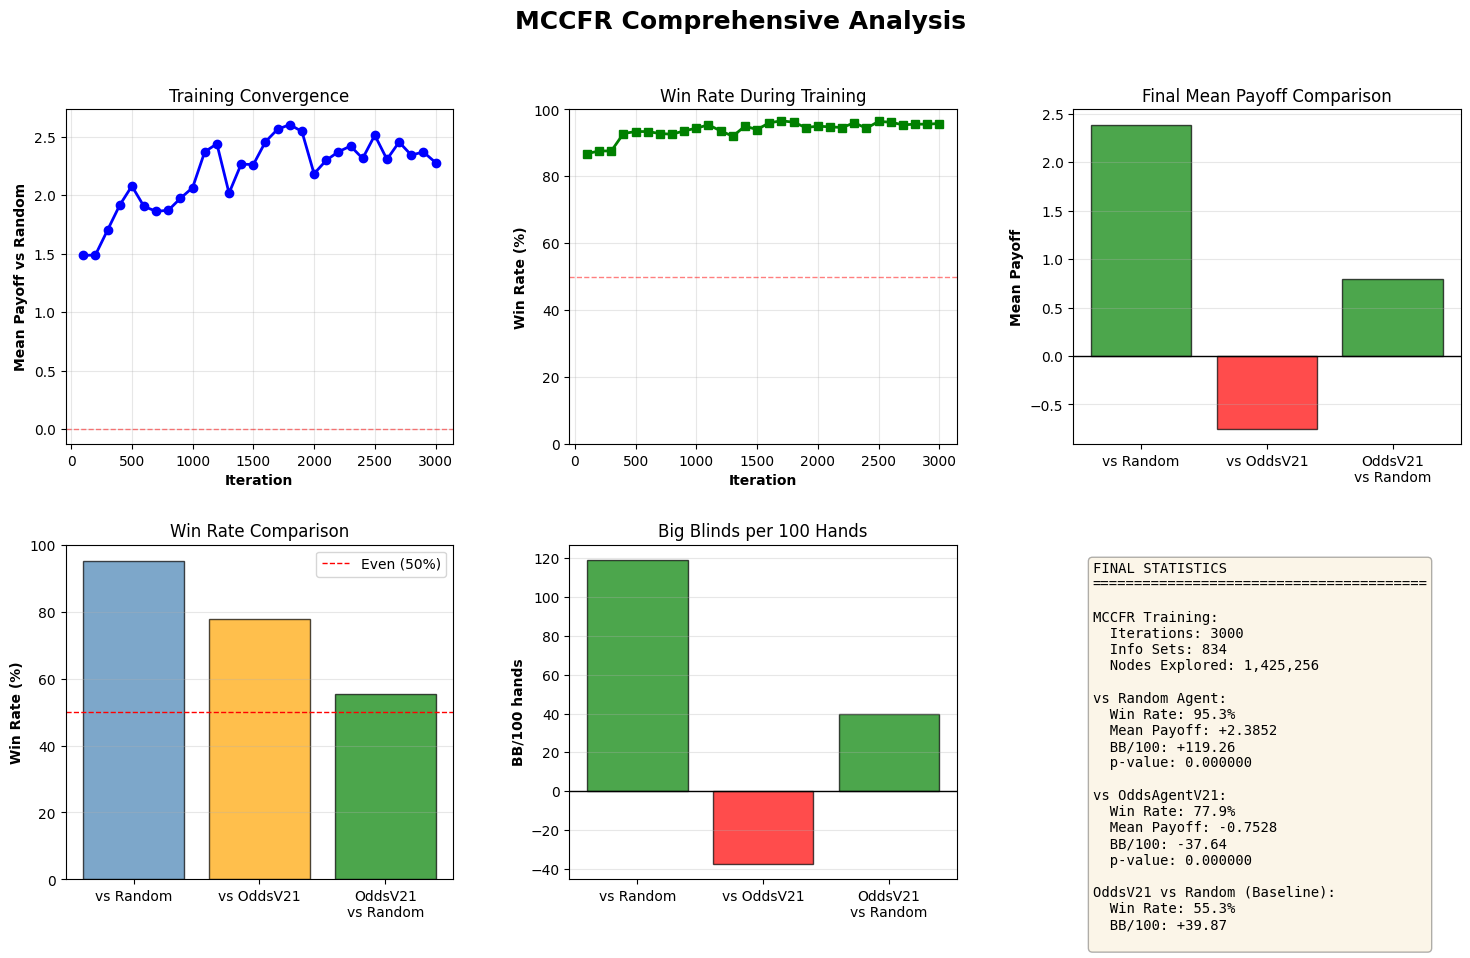

✓ Full comparison plots saved to mccfr_full_comparison.png

MCCFR PROJECT COMPLETE!

You now have:
  ✓ Trained MCCFR agent (3000 iterations)
  ✓ Evaluation vs Random Agent
  ✓ Evaluation vs OddsAgentV21
  ✓ Baseline comparison (OddsV21 vs Random)
  ✓ Comprehensive visualization
  ✓ Saved model file

Ready for your presentation! 🎉


In [ ]:
# CELL 5: Visualize Results (WITH ODDSAGENTV21)

# Plot training progress
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

fig.suptitle('MCCFR Comprehensive Analysis', fontsize=18, fontweight='bold')

# Plot 1: Training progress - Payoff
ax1 = fig.add_subplot(gs[0, 0])
iterations_list = [r['iteration'] for r in eval_results]
payoffs_list = [r['avg_payoff_random'] for r in eval_results]
ax1.plot(iterations_list, payoffs_list, 'b-', linewidth=2, marker='o')
ax1.axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('Iteration', fontweight='bold')
ax1.set_ylabel('Mean Payoff vs Random', fontweight='bold')
ax1.set_title('Training Convergence')
ax1.grid(True, alpha=0.3)

# Plot 2: Training progress - Win Rate
ax2 = fig.add_subplot(gs[0, 1])
win_rates_list = [r['win_rate_random'] for r in eval_results]
ax2.plot(iterations_list, win_rates_list, 'g-', linewidth=2, marker='s')
ax2.axhline(y=50, color='r', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Iteration', fontweight='bold')
ax2.set_ylabel('Win Rate (%)', fontweight='bold')
ax2.set_title('Win Rate During Training')
ax2.set_ylim([0, 100])
ax2.grid(True, alpha=0.3)

# Plot 3: Final Performance Comparison - Mean Payoff
ax3 = fig.add_subplot(gs[0, 2])
matchups = ['vs Random', 'vs OddsV21', 'OddsV21\nvs Random']
means = [results_vs_random['mean'], results_vs_odds['mean'], results_odds_vs_random['mean']]
colors = ['green' if m > 0 else 'red' if m < 0 else 'gray' for m in means]
ax3.bar(matchups, means, color=colors, alpha=0.7, edgecolor='black')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.set_ylabel('Mean Payoff', fontweight='bold')
ax3.set_title('Final Mean Payoff Comparison')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Win Rate Comparison
ax4 = fig.add_subplot(gs[1, 0])
win_rates = [results_vs_random['win_rate'], results_vs_odds['win_rate'],
             results_odds_vs_random['win_rate']]
colors = ['steelblue', 'orange', 'green']
ax4.bar(matchups, win_rates, color=colors, alpha=0.7, edgecolor='black')
ax4.axhline(y=50, color='red', linestyle='--', linewidth=1, label='Even (50%)')
ax4.set_ylabel('Win Rate (%)', fontweight='bold')
ax4.set_title('Win Rate Comparison')
ax4.set_ylim([0, 100])
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Plot 5: BB/100 Comparison
ax5 = fig.add_subplot(gs[1, 1])
bb_100s = [results_vs_random['bb_100'], results_vs_odds['bb_100'],
           results_odds_vs_random['bb_100']]
colors_bb = ['green' if bb > 0 else 'red' for bb in bb_100s]
ax5.bar(matchups, bb_100s, color=colors_bb, alpha=0.7, edgecolor='black')
ax5.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax5.set_ylabel('BB/100 hands', fontweight='bold')
ax5.set_title('Big Blinds per 100 Hands')
ax5.grid(axis='y', alpha=0.3)

# Plot 6: Statistical Summary Table (as text)
ax6 = fig.add_subplot(gs[1, 2])
ax6.axis('off')

summary_text = "FINAL STATISTICS\n" + "="*40 + "\n\n"
summary_text += f"MCCFR Training:\n"
summary_text += f"  Iterations: {ITERATIONS}\n"
summary_text += f"  Info Sets: {len(mccfr_agent.regret_sum):,}\n"
summary_text += f"  Nodes Explored: {mccfr_agent.total_game_nodes:,}\n\n"

summary_text += f"vs Random Agent:\n"
summary_text += f"  Win Rate: {results_vs_random['win_rate']:.1f}%\n"
summary_text += f"  Mean Payoff: {results_vs_random['mean']:+.4f}\n"
summary_text += f"  BB/100: {results_vs_random['bb_100']:+.2f}\n"
summary_text += f"  p-value: {results_vs_random['p_value']:.6f}\n\n"

summary_text += f"vs OddsAgentV21:\n"
summary_text += f"  Win Rate: {results_vs_odds['win_rate']:.1f}%\n"
summary_text += f"  Mean Payoff: {results_vs_odds['mean']:+.4f}\n"
summary_text += f"  BB/100: {results_vs_odds['bb_100']:+.2f}\n"
summary_text += f"  p-value: {results_vs_odds['p_value']:.6f}\n\n"

summary_text += f"OddsV21 vs Random (Baseline):\n"
summary_text += f"  Win Rate: {results_odds_vs_random['win_rate']:.1f}%\n"
summary_text += f"  BB/100: {results_odds_vs_random['bb_100']:+.2f}\n"

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
         fontsize=10, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.savefig('mccfr_full_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Full comparison plots saved to mccfr_full_comparison.png")

print(f"\n{'='*80}")
print("MCCFR PROJECT COMPLETE!")
print(f"{'='*80}")
print(f"\nYou now have:")
print(f"  ✓ Trained MCCFR agent ({ITERATIONS} iterations)")
print(f"  ✓ Evaluation vs Random Agent")
print(f"  ✓ Evaluation vs OddsAgentV21")
print(f"  ✓ Baseline comparison (OddsV21 vs Random)")
print(f"  ✓ Comprehensive visualization")
print(f"  ✓ Saved model file")
print(f"\nReady for your presentation! 🎉")